In [2]:
import pandas as pd 
import numpy as np 
import os 
import time
import logging 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold 

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from category_encoders import TargetEncoder

from tqdm.auto import tqdm
from itertools import combinations
import warnings
warnings.simplefilter('ignore')

ModuleNotFoundError: No module named 'category_encoders'

# １．Data Loding

In [ ]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

In [ ]:
train

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...,...
749995,749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,749998,male,45,182.0,91.0,17.0,102.0,40.3,109.0


In [ ]:
test

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5
...,...,...,...,...,...,...,...,...
249995,999995,female,56,159.0,62.0,6.0,85.0,39.4
249996,999996,male,32,202.0,101.0,3.0,84.0,38.4
249997,999997,female,31,164.0,64.0,14.0,98.0,40.1
249998,999998,female,62,158.0,61.0,25.0,106.0,40.7


# ２．EDA

In [ ]:
columns_to_plot = [col for col in train.columns if col not in ['id', 'Sex','Calories']]
columns_to_plot

['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

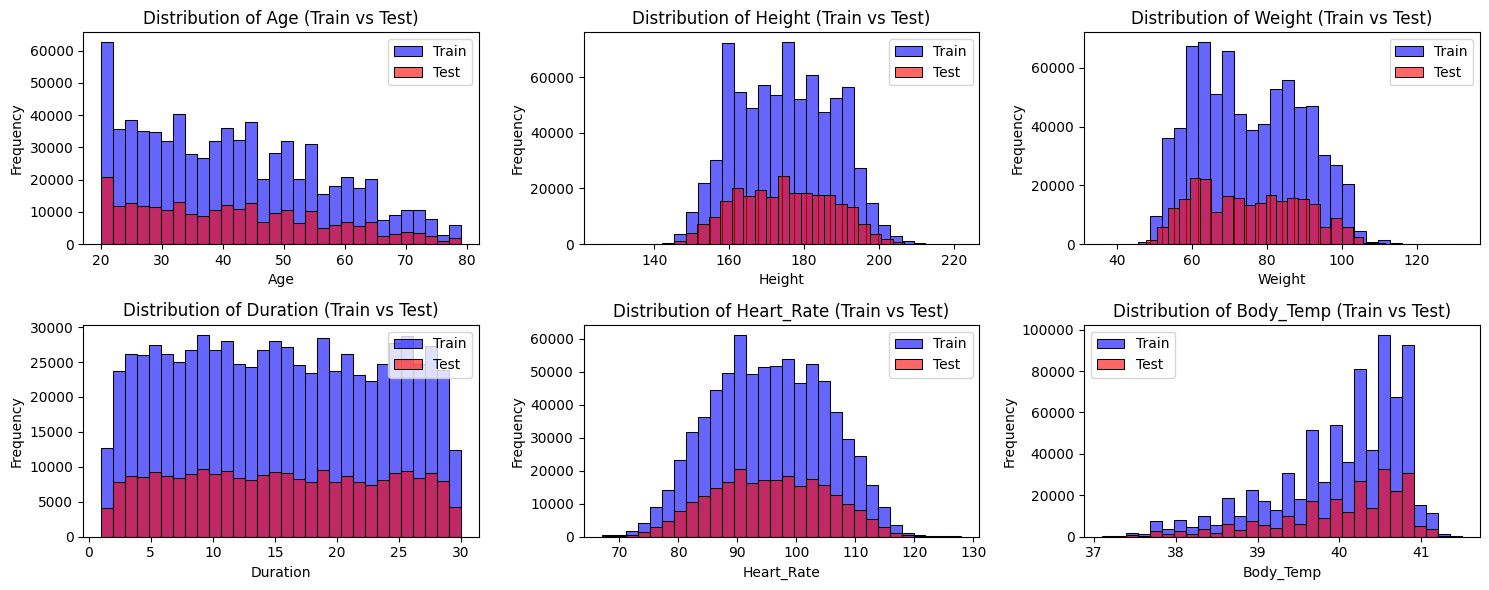

In [ ]:
num_cols = 3  
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3* num_rows))  


for i, col in enumerate(columns_to_plot):
    row = i // num_cols  
    col_num = i % num_cols  
    ax = axes[row, col_num] 
    
    sns.histplot(train[col], label='Train', color='blue', kde=False, bins=30, alpha=0.6, ax=ax)
    sns.histplot(test[col], label='Test', color='red', kde=False, bins=30, alpha=0.6, ax=ax)
    ax.set_title(f'Distribution of {col} (Train vs Test)')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()

for j in range(len(columns_to_plot), num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])  

plt.tight_layout() 
plt.show()

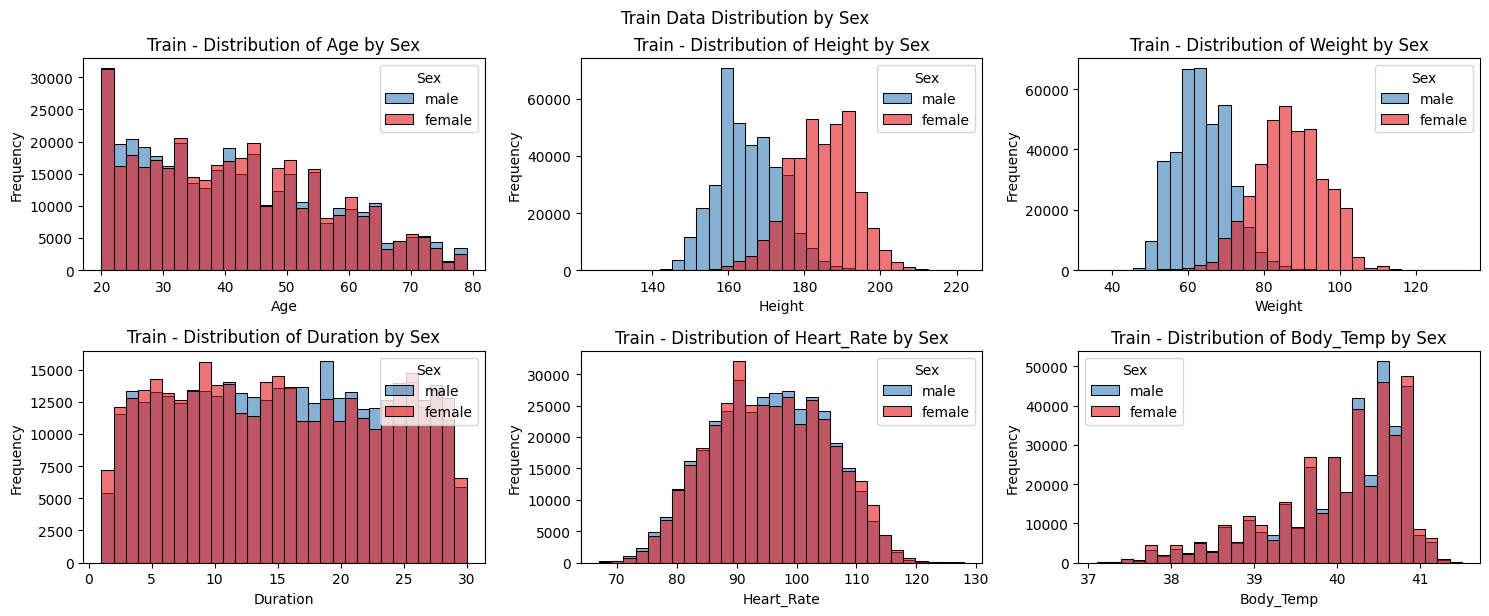

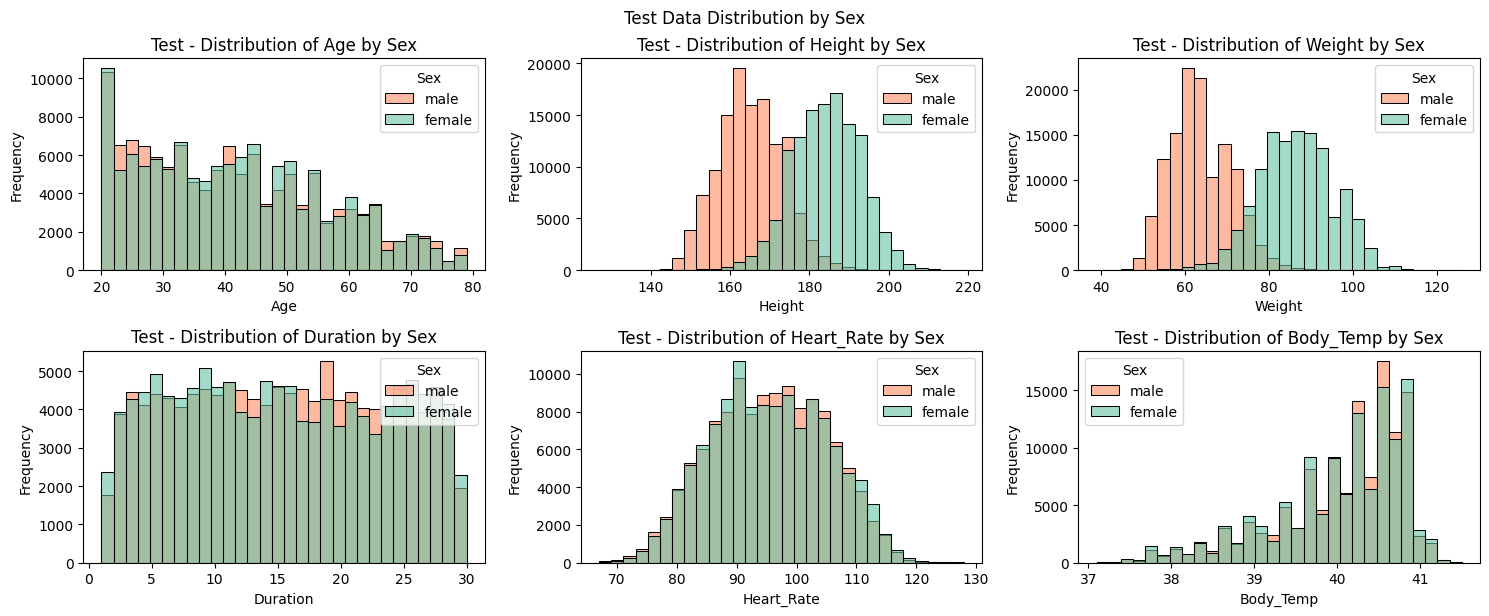

In [ ]:
num_cols = 3
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

for i, col in enumerate(columns_to_plot):
    row = i // num_cols
    col_num = i % num_cols
    ax = axes[row, col_num]
    sns.histplot(data=train, x=col, hue='Sex', kde=False, bins=30, alpha=0.6, ax=ax, palette="Set1")
    ax.set_title(f'Train - Distribution of {col} by Sex')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend(title='Sex', labels=['male', 'female']) 

for j in range(len(columns_to_plot), num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.suptitle('Train Data Distribution by Sex', y=1.02)
plt.show()

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

for i, col in enumerate(columns_to_plot):
    row = i // num_cols
    col_num = i % num_cols
    ax = axes[row, col_num]
    sns.histplot(data=test, x=col, hue='Sex', kde=False, bins=30, alpha=0.6, ax=ax, palette="Set2")
    ax.set_title(f'Test - Distribution of {col} by Sex')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend(title='Sex', labels=['male', 'female']) 

for j in range(len(columns_to_plot), num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.suptitle('Test Data Distribution by Sex', y=1.02)
plt.show()

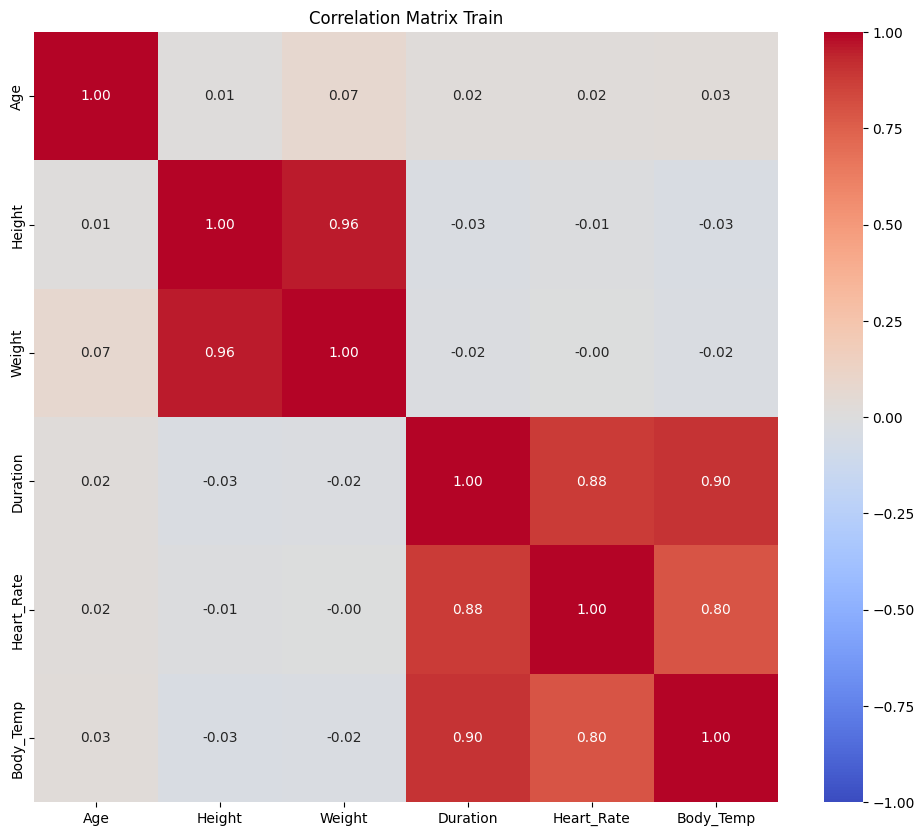

In [ ]:
correlation_matrix = train[columns_to_plot].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Train")
plt.show()

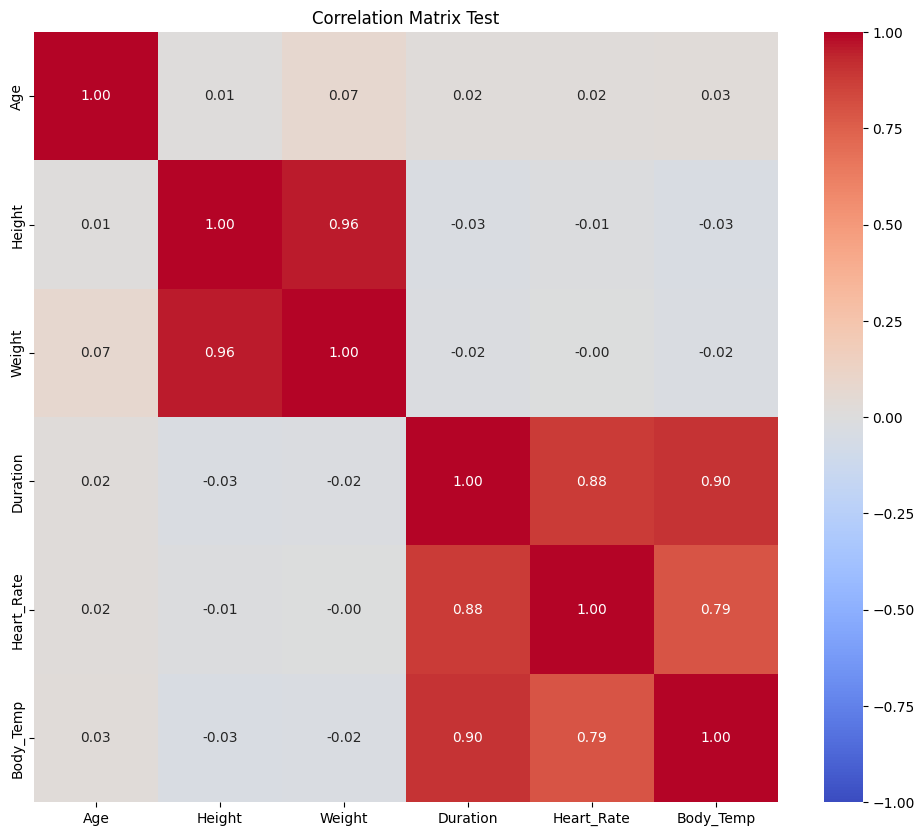

In [ ]:
correlation_matrix = test[columns_to_plot].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Test")
plt.show()

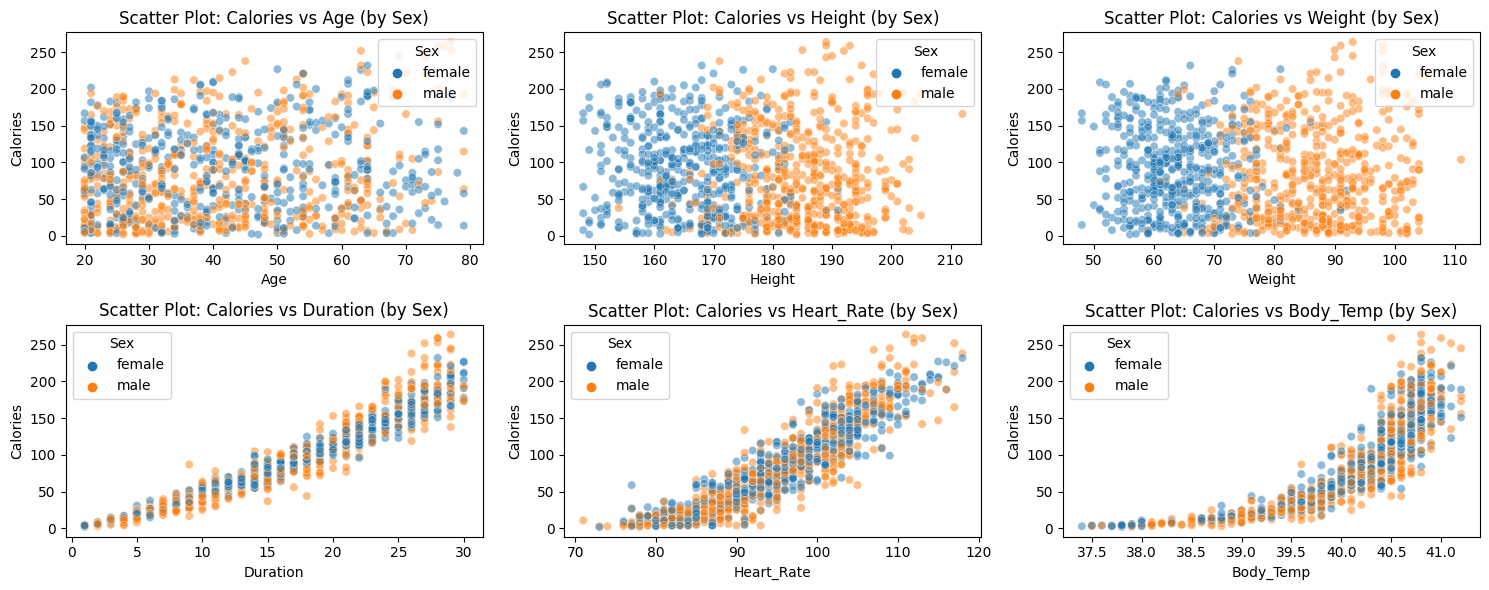

In [ ]:
train_sample = train.sample(n=1000, random_state=42)

num_cols = 3
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

for i, col in enumerate(columns_to_plot):
    row = i // num_cols  
    col_num = i % num_cols 
    ax = axes[row, col_num]  
    sns.scatterplot(x=train_sample[col], y=train_sample['Calories'], hue=train_sample['Sex'], alpha=0.5, ax=ax)
    ax.set_title(f'Scatter Plot: Calories vs {col} (by Sex)')
    ax.set_xlabel(col)
    ax.set_ylabel('Calories')
    ax.legend(title='Sex')

for j in range(len(columns_to_plot), num_rows * num_cols):
    fig.delaxes(axes.flatten()[j]) 

plt.tight_layout()  
plt.show()

# ３．Preprocessing

In [ ]:
le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.transform(test['Sex'])

train["Sex"] = train["Sex"].astype("category")
test["Sex"] = test["Sex"].astype("category")

drop_columns = ["id"]
X = train.drop(columns=drop_columns + ['Calories']) 
y = np.log1p(train["Calories"])
X_test = test.drop(columns=drop_columns )

# ４．Training!

In [ ]:
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
n_fold = 5
n_repeat = 3 
cv = RepeatedKFold(n_splits=n_fold, n_repeats=n_repeat, random_state=0)

n_fold = n_fold * n_repeat
y_pred_train = np.zeros(len(X)) 
y_pred_test = np.zeros(len(X_test)) 
importances = pd.DataFrame(
    np.zeros(len(X.columns)), index=X.columns, columns=['importance'])  
scores = []  

for i, (train_index, val_index) in enumerate(cv.split(X, y)):
    X_train_, y_train_ = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
    
    model = LGBMRegressor(
        learning_rate=0.03, num_leaves=31, n_estimators=1999, 
        objective='mse', colsample_bytree=0.7, subsample=0.9, 
        verbose=-1, random_state=0
    )
    
    model.fit(
        X_train_, y_train_, 
        eval_set=[(X_val, y_val)],  
        eval_metric='mae',  
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )
    
    y_pred_val = np.expm1(model.predict(X_val)) 
    y_pred_test += np.expm1(model.predict(X_test)) / n_fold  
    importances['importance'] += model.feature_importances_ / n_fold  
    
    y_pred_train[val_index] = y_pred_val
    
    y_val_orig = np.expm1(y_val)  
    score = mean_squared_log_error(y_val_orig, y_pred_val)**0.5
    scores.append(score)
    
    print("Fold%d RMSLE: %f" % (i, score))

print("Overall RMSLE: %f±%f" % (np.mean(scores), np.std(scores)))

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's l1: 0.0346403	valid_0's l2: 0.00355255
Fold0 RMSLE: 0.059603
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's l1: 0.034555	valid_0's l2: 0.00361024
Fold1 RMSLE: 0.060085
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's l1: 0.0346462	valid_0's l2: 0.00355525
Fold2 RMSLE: 0.059626
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's l1: 0.0344724	valid_0's l2: 0.00354491
Fold3 RMSLE: 0.059539
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1999]	valid_0's l1: 0.0346599	valid_0's l2: 0.00369131
Fold4 RMSLE: 0.060756
Training until validation scores don't improve for 50 rounds
Did n

In [ ]:
importances = importances.sort_values(by='importance', ascending=False)
print("Feature Importances:")
importances

Feature Importances:


,importance
Heart_Rate,12332.333333
Age,10300.533333
Duration,9185.200000
Body_Temp,9070.133333
Weight,7961.200000
Height,6644.733333
Sex,2483.866667


In [ ]:
plt.figure()  
plt.scatter(y_pred_train, np.expm1(y), s=1)  
min_val, max_val = min(np.expm1(y)), max(np.expm1(y))
plt.plot([min_val, max_val], [min_val, max_val], 'b--', label='y = x') 
plt.xlabel('y_pred')  
plt.ylabel('y_true')  
plt.show()

NameError: name 'plt' is not defined

# ５．Submission

In [ ]:
y_preds = y_pred_test
print('predict mean :',y_preds.mean())
print('predict median :',np.median(y_preds))

y_preds = np.clip(y_preds,1,314)
print('predict mean after clip:',y_preds.mean())
print('predict median after clip:',np.median(y_preds))

submission["Calories"] = y_preds
submission.to_csv("submission.csv", index=False)
submission.head()

predict mean : 88.17875744973735
predict median : 76.47176226357513
predict mean after clip: 88.17875746863595
predict median after clip: 76.47176226357513


,id,Calories
0,750000,26.830669
1,750001,109.271205
2,750002,87.263151
3,750003,124.154385
4,750004,75.870584
